##  Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
## Camera calibration

Could not use ./camera_cal/calibration1.jpg for calibration.
Could not use ./camera_cal/calibration5.jpg for calibration.
Could not use ./camera_cal/calibration4.jpg for calibration.


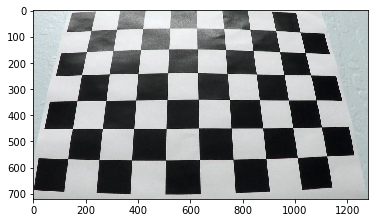

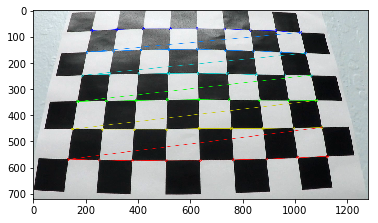

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objPoint = np.zeros((6 * 9, 3), np.float32)
objPoint[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images
objPoints = [] # 3d points in real world space
imgPoints = [] # 2d points in image plane

# Make a list of calibration images
calibrationImages = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fileName in calibrationImages:
    image = cv2.imread(fileName)
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(imageGray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objPoints.append(objPoint)
        imgPoints.append(corners)

        # Draw and display the corners
        imgWithCorners = cv2.drawChessboardCorners(np.copy(image), (9,6), corners, ret)
        
        # Handpicked example to show chessboard corner detection
        if fileName == './camera_cal/calibration3.jpg':
            plt.figure()
            plt.imshow(image)
            plt.figure()
            plt.imshow(imgWithCorners)
    # If not found, print warning to console        
    else:
        print('Could not use ' + fileName + ' for calibration.')

## Distortion Correction

In [2]:
# Performs the camera calibration, image distortion correction and returns the undistorted image
def undistortImage(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

undistortImage being used on a chessboard image

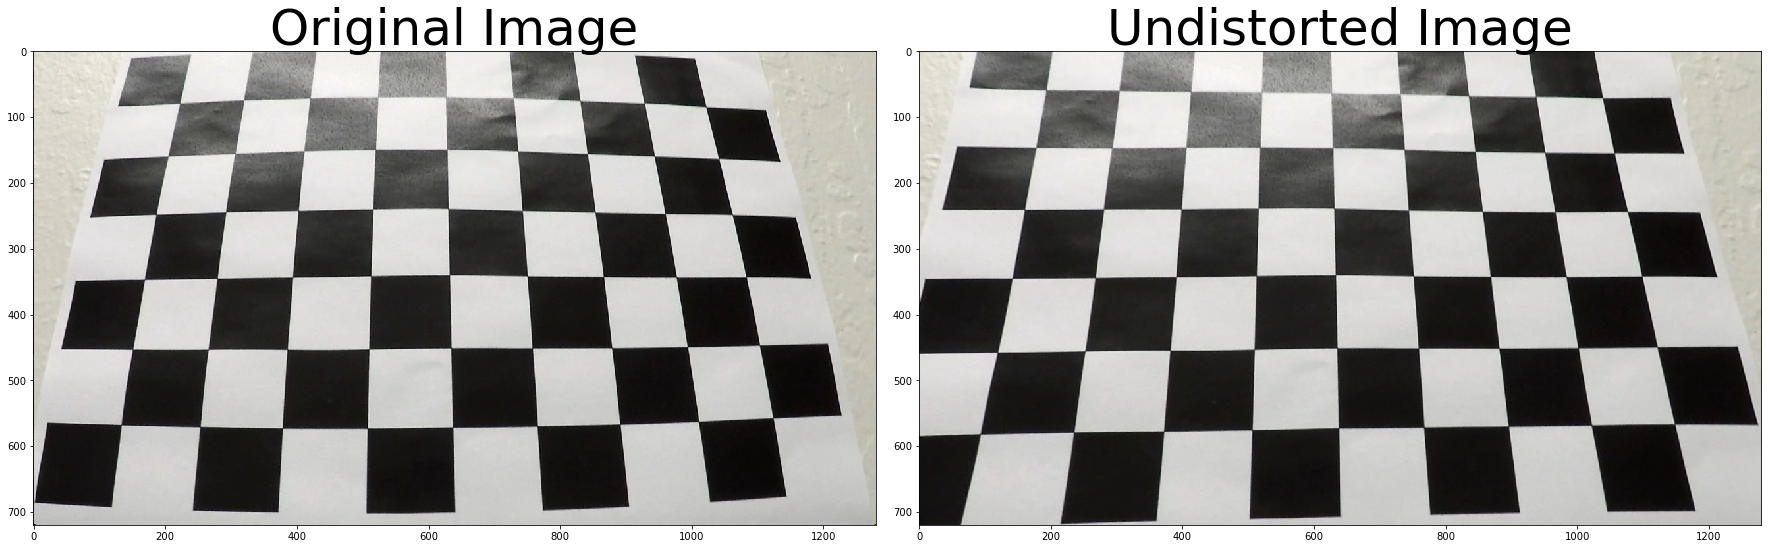

In [3]:
example = mpimg.imread('./camera_cal/calibration3.jpg')

exampleUndistorted = undistortImage(example, objPoints, imgPoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(example)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(exampleUndistorted)
ax2.set_title('Undistorted Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

undistortImage being used on a road image

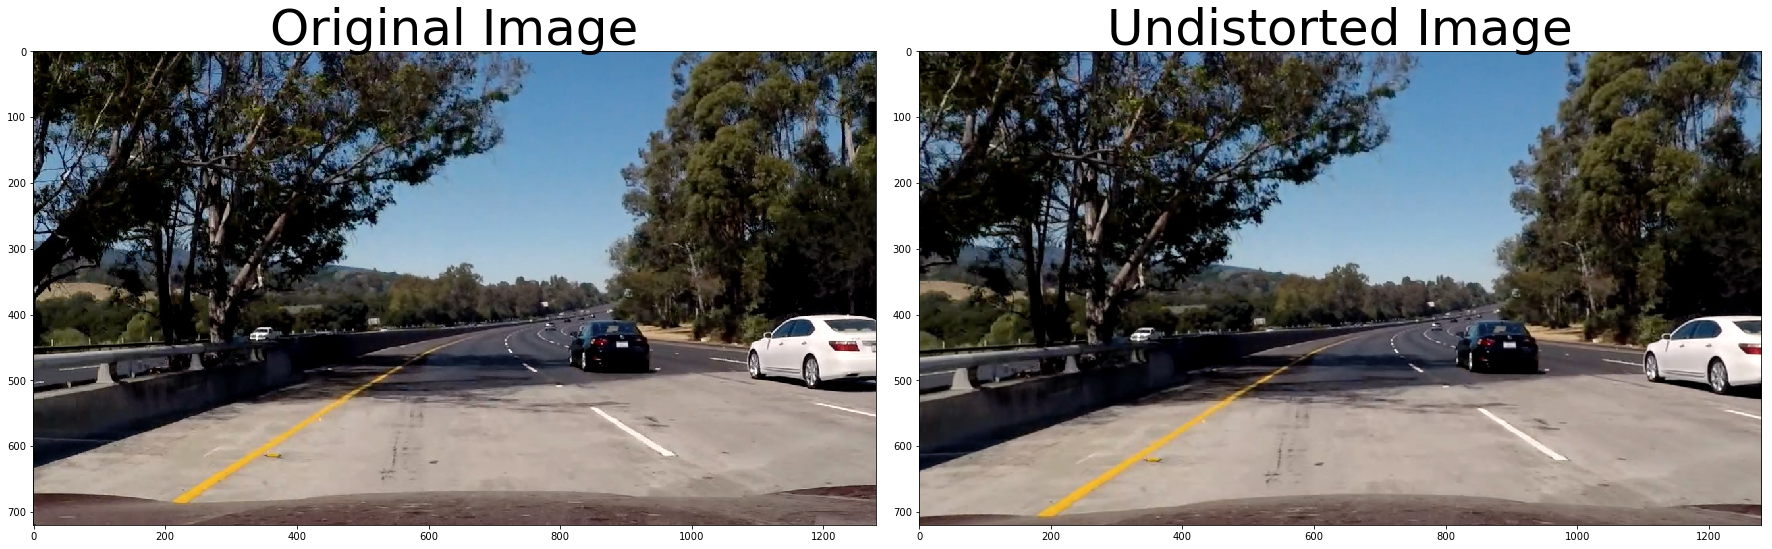

In [4]:
example = mpimg.imread('./test_images/test5.jpg');

exampleUndistorted = undistortImage(example, objPoints, imgPoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(example)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(exampleUndistorted)
ax2.set_title('Undistorted Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Binary Image Creation

Below are some helper functions

In [8]:
# Define a function that takes an image, gradient orientation, and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [9]:
# Define a function that applies Sobel x and y, then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255 
    gradmag = (gradmag / scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [10]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [11]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [12]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

The cell below makes use of all of the helper functions tied to the binary image creation

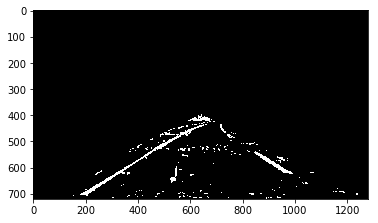

In [13]:
# Takes in an undistorted image as input
# Returns a binarized image
def binarizeImage(image):
    # Apply each of the thresholding functions
    hls = hls_select(image, thresh=(170, 255))
    
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=5, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=2, thresh_max=100)
    
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    
    # Create a blank binary image
    combined = np.zeros_like(gradx)
    
    # Turns combined into thresholded image
    combined[(gradx == 1) & (grady == 1) | ((mag_binary == 1) & (dir_binary == 1)) | ((hls == 1))] = 255
    
    # Median filter
    combined = cv2.medianBlur(combined.copy(), 5)
    
    # Region mask
    imageShape = combined.shape
    
    # Target: bottom left
    v1 = (0, imageShape[0])
    # Target: top center, height manually tuned by a percentage ex: 0.55
    v2 = ((imageShape[1] / 2), (imageShape[0] * 0.55))
    # Target: bottom right
    v3 = (imageShape[1], imageShape[0])
    
    vertices = np.array([[v1,v2,v3]], dtype=np.int32)
    combined = region_of_interest(combined.copy(), vertices)
    
    return combined

exampleBinary = binarizeImage(exampleUndistorted)

plt.figure()
plt.imshow(exampleBinary, cmap='gray')

## Perspective Transform

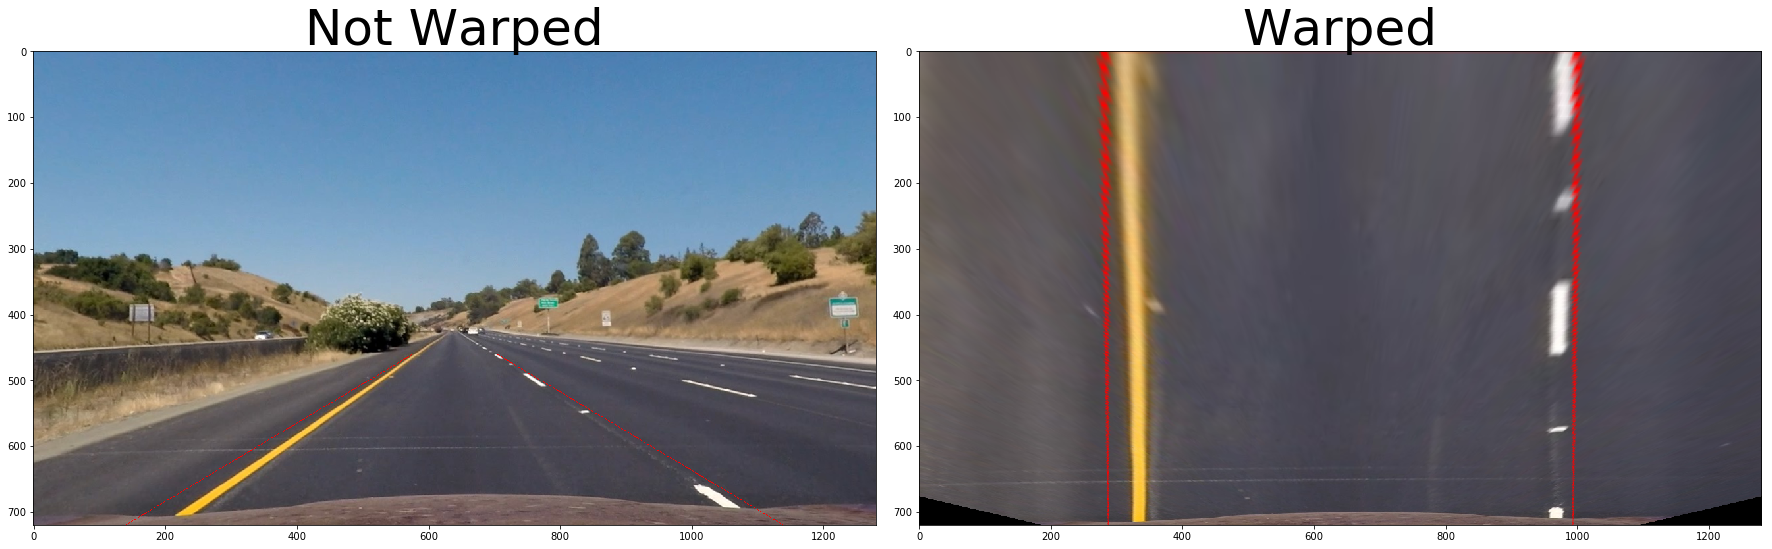

In [14]:
straightImage = mpimg.imread('./test_images/straight_lines1.jpg')

straightImageUndistorted = undistortImage(straightImage, objPoints, imgPoints)

# Manually tune perspective transform values
img_height = straightImageUndistorted.shape[0]
img_width = straightImageUndistorted.shape[1]

topOffsetX = 0.45
topOffsetY = 0.64
topRight = [(img_width * ( 1 - topOffsetX)) , img_height * topOffsetY]
topLeft = [img_width * topOffsetX, img_height * topOffsetY]

bottomOffset = 0.11
bottomRight = [(img_width * (1 - bottomOffset)), img_height]
bottomLeft = [img_width * bottomOffset, img_height]

pts = np.array([topRight, bottomRight, bottomLeft, topLeft], np.int32)
pts = pts.reshape((-1,1,2))

cv2.polylines(straightImageUndistorted, [pts], True, (255, 0, 0), thickness=1)

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    # source pts needs better ones
    src = np.float32([topRight, bottomRight, bottomLeft, topLeft])
    
    middle = (img_width / 2)
    offset = middle * 0.55
    
    # destination pts
    dst = np.float32([[middle + offset, 0],
                      [middle + offset, img_height],
                      [middle - offset, img_height],
                      [middle - offset, 0]])
    
    # compute perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # compute inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # warp using perspective transform
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped


straightImageWarped = warp(straightImageUndistorted)

# Plots to show the difference
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(straightImageUndistorted)
ax1.set_title('Not Warped', fontsize=50)

ax2.imshow(straightImageWarped)
ax2.set_title('Warped', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

The code below applies a perspective transform to rectify the example binary image

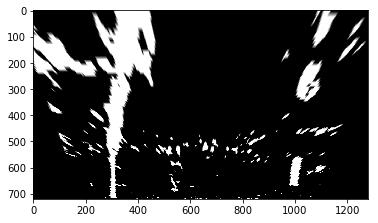

In [15]:
exampleWarped = warp(exampleBinary)
plt.imshow(exampleWarped, cmap='gray')

## Detection Of Lane Pixels

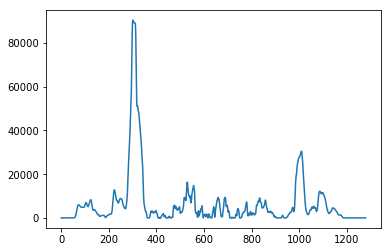

In [16]:
exampleHistogram = np.sum(exampleWarped[exampleWarped.shape[0]//2:,:], axis=0)
plt.plot(exampleHistogram)

Sliding window search exploration area below -- did not end up using this approach

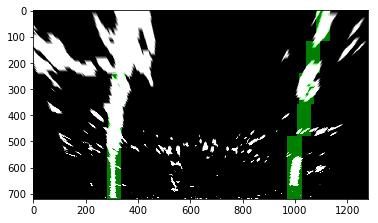

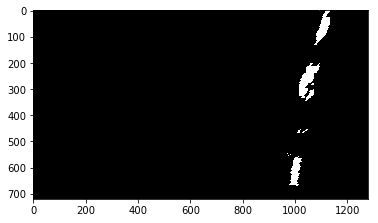

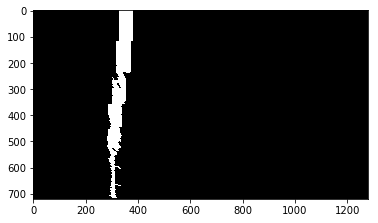

In [17]:
# window settings
window_width = 55
window_height = 120 # Break image into 9 vertical layers since image height is 720
margin = 40 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

warped = np.copy(exampleWarped)
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together

        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green        
        
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    #If no window centers found, just display original road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.show()

# get right lane pixels
r_pixels = np.zeros_like(exampleWarped)
r_pixels[(r_points == 255) & (exampleWarped == 255)] = 255
plt.figure()
plt.imshow(r_pixels, cmap='gray')

# get left lane pixels
l_pixels = np.zeros_like(exampleWarped)
l_pixels[(l_points == 255) & (exampleWarped == 255)] = 255
plt.figure()
plt.imshow(l_pixels, cmap='gray')

The code below helps visualize what is going on inside of the createOverlay function thats coming up

(720, 0)

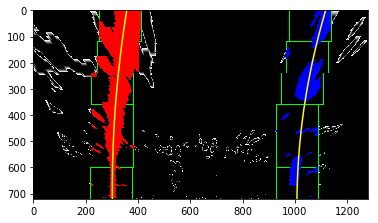

In [18]:
histogram = np.sum(exampleWarped[exampleWarped.shape[0]//2:,:], axis=0)

binary_warped = np.copy(exampleWarped)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 6
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 80
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

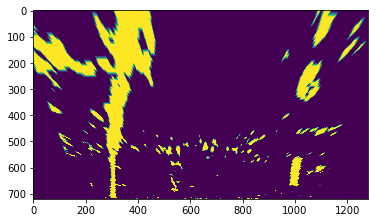

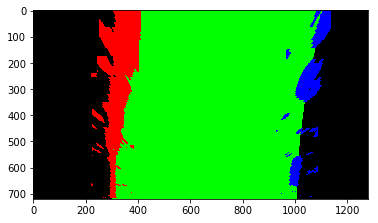

In [19]:
# If data is present inside of fit createOverlay wont have to do the entire fit line process
fit = []

# Takes in a warped binary image, and an undistorted rgb image
# Returns a RGB image that shows lane information
# The function also updates line fits (non-corrected and corrected)
def createOverlay(image, undistorted):
    # These values can be tweaked, but for now it is assumed that lane length is 30m and width 3.7m
    ym_per_pix = 30 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension
    
    global fit
    # If there are no fit lines that can be used do additional steps
    if len(fit) == 0:
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0] / 2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 6
        # Set height of windows
        window_height = np.int(binary_warped.shape[0] / nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 80
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window + 1) * window_height
            win_y_high = binary_warped.shape[0] - window * window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Update line fit
        fit.append(left_fit)
        fit.append(right_fit)
        
        # Update corrected line fit
        left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2) 
        fit.append(left_fit_cr)
        fit.append(right_fit_cr)
    else:
        # If already have a line, blind search is not needed. Search in a margin around the previous line position
        # Assume warped binary image as starting point
        left_fit = fit[0]
        right_fit = fit[1]
        
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 80
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Update line fit
        fit[0] = left_fit
        fit[1] = right_fit
        
        # Update corrected line fit
        left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
        fit[2] = left_fit_cr
        fit[3] = right_fit_cr
        
    # Overlay creation
    overlay = np.zeros_like(undistorted)
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Points for drawing the road overlay
    left_points = np.column_stack((left_fitx, ploty))
    right_points = np.column_stack((right_fitx, ploty))
    right_rev = right_points[::-1]
    points_combined = np.vstack((left_points, right_rev))
    cv2.fillPoly(overlay, np.int_([points_combined]), (0, 255, 0))
    
    overlay[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    overlay[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
    return overlay

plt.figure()
plt.imshow(exampleWarped)

plt.figure()
plt.imshow(createOverlay(exampleWarped, exampleUndistorted))

Exploration for determining the curvature of the lane and vehicle position with respect to the center

1782.51697584 1535.48728458
585.431907564 m 503.867408749 m


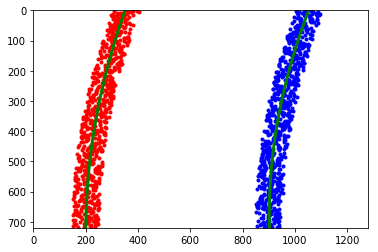

In [20]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720) # to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

# Example values: 1926.74 1908.48
print(left_curverad, right_curverad)

# http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm
# Assume selected lane area is 30 meters long and 3.7 meters wide
# Values can be tweeked later if needed
# Define conversions in x and y from pixels space to meters
lane_length = 30 # (meters)
lane_width = 3.7 # (meters)

ym_per_pix = lane_length / 720 # meters per pixel in y dimension
xm_per_pix = lane_width / 700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
# Example values: 632.1 m 626.2 m
print(left_curverad, 'm', right_curverad, 'm')

In [25]:
# Returns a string with radius of curvature information, assumes fit line 
def getCurvature():
    global fit
    
    # Define y-value where we want radius of curvature
    # maximum y-value, corresponding to the bottom of the image
    y_eval = 719
    
    left_fit_cr =  fit[2]
    right_fit_cr = fit[3]
    
    # Calculate the new radii of curvature (corrected)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # Example values: 632.1 m 626.2 m
    
    curvature = (left_curverad + right_curverad) / 2
    
    return "Radius of curvature = " + str(round(curvature, 2)) + "(m)"

In [24]:
# Could improve, assumes vehicle in lane and both lanes can be seen
# Returns string for vehicle position in meters
# Takes in left, right and center pixels
# - is left + is right
#eyes on this maybe wrong
def getVehiclePosition(img):
    global fit
    
    center =  img.shape[1] / 2
    
    # maximum y-value, corresponding to the bottom of the image, for lane boundaries
    y_eval = 719
    
    left_fit = fit[0]
    left = left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]
    
    right_fit = fit[1]
    right = right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2]
     
    laneLength_pixels = right - left
    laneLength_meters = 3.7 # This can be tuned
    
    laneCenter = (left + right) / 2
    
    vehiclePosition_pixels = laneCenter - center # Distance from lane center
    vehiclePosition_meters = (vehiclePosition_pixels * laneLength_meters) / laneLength_pixels

    positionStr = ""

    if vehiclePosition_meters >= 0:
        positionStr = "right"
    else:
        positionStr = "left"

    return "Vehicle is " + str(round(abs(vehiclePosition_meters), 2)) + "(m) " + positionStr +" of center"

In [26]:
def unwarp(img):
    img_size = (img.shape[1], img.shape[0])
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    # source pts needs better ones
    src = np.float32([topRight, bottomRight, bottomLeft, topLeft])
    
    middle = (img_width / 2)
    offset = middle * 0.55
    
    # destination pts
    dst = np.float32([[middle + offset, 0],
                      [middle + offset, img_height],
                      [middle - offset, img_height],
                      [middle - offset, 0]])
    
    # compute perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # compute inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # warp using perspective transform
    warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)

    return warped

The image processing pipeline

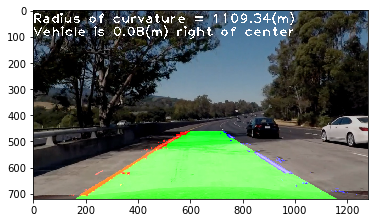

In [27]:
image = mpimg.imread('./test_images/test5.jpg')

# Global fit variable holds line fit values, hacky solution, can be improved but works for now
# If fit is empty, it will fit a line from scratch
# If fit has data from previous searches it will update with only the binary image
fit = []
def processImage(image):
    image = undistortImage(image, objPoints, imgPoints)
    imageBinary = binarizeImage(image)
    imageBinaryWarped = warp(imageBinary)
    imageOverlay = createOverlay(imageBinaryWarped, image)
    
    curvature = getCurvature()
    vehiclePos = getVehiclePosition(image)
    
    imageUnwarped = unwarp(imageOverlay)
    
    finalImage = np.zeros_like(image)
    finalImage = cv2.addWeighted(image, 0.8, imageUnwarped, 1, 0.0)

    cv2.putText(finalImage, curvature, (0, 50), 1, 3.5, (255, 255, 255), 4)

    cv2.putText(finalImage, vehiclePos, (0, 100), 1, 3.5, (255, 255, 255), 4)
    
    return finalImage

plt.figure()
plt.imshow(processImage(image))

## Testing image processing pipeline on test images

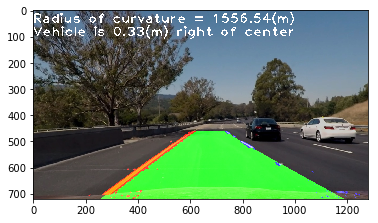

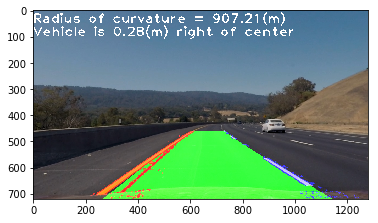

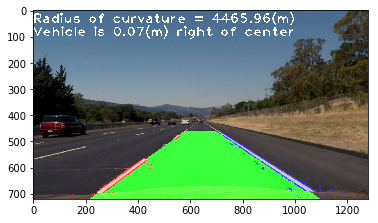

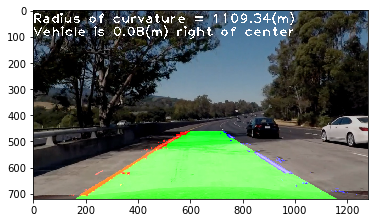

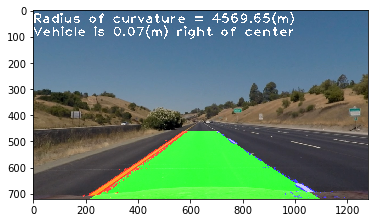

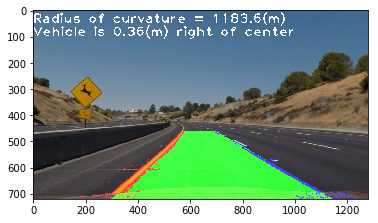

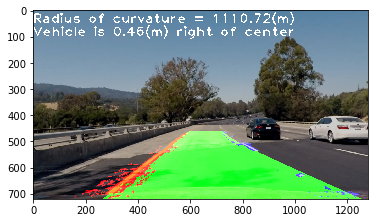

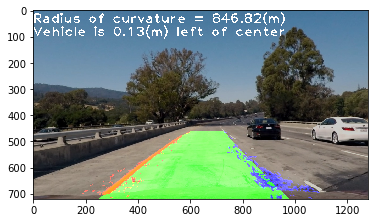

In [28]:
test_images = glob.glob('./test_images/*')

for fileName in test_images:
    fit = []
    
    img = mpimg.imread(fileName)
    img = processImage(img)
    
    plt.figure()
    plt.imshow(img)

## Pipeline on regular video

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

fit = []

output = 'regular.mp4'

clip = VideoFileClip("project_video.mp4")

project_clip = clip.fl_image(processImage)

%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video regular.mp4
[MoviePy] Writing video regular.mp4


100%|█████████▉| 1260/1261 [21:47<00:01,  1.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: regular.mp4 

CPU times: user 23min 42s, sys: 4.74 s, total: 23min 46s
Wall time: 21min 48s


## Pipeline on challenge video

In [31]:
fit = []

output = 'challenge.mp4'

clip = VideoFileClip("challenge_video.mp4")

project_clip = clip.fl_image(processImage)

%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge.mp4
[MoviePy] Writing video challenge.mp4


100%|██████████| 485/485 [07:48<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge.mp4 

CPU times: user 8min 34s, sys: 4.25 s, total: 8min 38s
Wall time: 7min 49s


## Pipeline on harder challenge video

In [32]:
fit = []

output = 'challengeHarder.mp4'

clip = VideoFileClip("harder_challenge_video.mp4")

project_clip = clip.fl_image(processImage)

%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challengeHarder.mp4
[MoviePy] Writing video challengeHarder.mp4


100%|█████████▉| 1199/1200 [20:41<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challengeHarder.mp4 

CPU times: user 22min 27s, sys: 13 s, total: 22min 40s
Wall time: 20min 43s
